In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Model
import tensorflow.keras.backend as K
import numpy as np

In [3]:
Tx = 250
Ty = Tx //2

In [4]:
def softmax(x, axis=1):
    ndim = K.ndim(x)
    if ndim == 2:
        return K.softmax(x)
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')

In [5]:
def one_step_attention(a, s_prev):
    s_prev = RepeatVector(Tx)(s_prev)
    
    concat = Concatenate(axis=-1)([a,s_prev])
    
    e = Dense(10, activation = "tanh")(concat)
    
    energies = Dense(1, activation = "relu")(e)
    
    alphas = Activation(softmax)(energies)
    
    context = Dot(axes = 1)([alphas,a])
    
    
    return context

In [6]:
n_a = 32 # number of units for the pre-attention, bi-directional LSTM's hidden state 'a'
n_s = 64 # number of units for the post-attention LSTM's hidden state "s"

In [7]:
def generate_model(Tx, Ty, n_a, n_s, no_of_channels):
    
    X = Input(shape=(Tx, no_of_channels))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0

    outputs = []

    a =  Bidirectional(LSTM(units=n_a, return_sequences=True, recurrent_dropout=0.25, name = "bilstm-pre"))(X)

    for t in range(Ty):
    
        
        context = one_step_attention(a, s)
        
        s, _, c = LSTM(n_s, return_state = True)(inputs=context , initial_state=[s, c])
        
        
        out = Dense(1, activation="sigmoid")(s)
        
        
        outputs.append(out)
    
    outputs = Concatenate(axis=-1)(outputs) 
    out1 = Dense(Ty//2, activation = "relu")(outputs)
    out1 = Dropout(0.5)(out1)
    out1 = Dense(32, activation = "relu")(out1)
    out1 = Dropout(0.5)(out1)
    out1 = Dense(20, activation = "relu")(out1)
    out1 = Dropout(0.5)(out1)
    out1 = Dense(1, activation = "sigmoid")(out1)

    model = Model(inputs=[X, s0, c0], outputs=out1 )

    
    return model

In [8]:
model = generate_model(Tx, Ty, n_a, n_s, 20)

In [11]:
# tf.keras.utils.plot_model(model,"m1.png")

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 20)]    0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 [(None, 64)]         0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 250, 64)      13568       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 250, 64)      0           s0[0][0]                         
______________________________________________________________________________________________

In [13]:
from tensorflow.keras.utils import to_categorical
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt
#from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
# import pydot, graphviz
import scipy.io


Bad key "text.kerning_factor" on line 4 in
/home/shreya/anaconda3/envs/mudit/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [14]:
import tensorflow as tf

# Check that GPU is available: cf. https://colab.research.google.com/notebooks/gpu.ipynb
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [15]:
os.chdir("/home/shreya/ArithmeticTask/ArithmeticTask_Data_set_csv")
#os.chdir("/home/shreya/Documents/IIIT_D/ArithmeticTask_Data_set_csv")
list_df = np.array([[[[]]]])
list_y = []
for data_file in sorted(os.listdir()):
    if("y" in data_file):
        y = pd.DataFrame(pd.read_csv(data_file))
        y.drop("Unnamed: 0", axis=1, inplace=True)
        list_y = y.to_numpy()
    else:
        df = pd.DataFrame(pd.read_csv(data_file))
        df.drop("Unnamed: 0", axis=1, inplace=True)
        if("00_1" in data_file):
            list_df = np.array([[df.to_numpy()]])
        else:
            list_df = np.append(list_df, np.array([[df.to_numpy()]]), axis = 0)

In [16]:
nlist_df = list_df.reshape(list_df.shape[0],list_df.shape[2], list_df.shape[3])

In [17]:
nlist_df.shape

(72, 20, 30000)

In [18]:
window_size = 250

In [19]:
Ytrain = np.zeros((1,1))

In [20]:
Xtrain = np.zeros((1,250, 20))

In [21]:
for i in range(0, nlist_df.shape[0]):
    for j in range(0, nlist_df.shape[2]//window_size):
        window = nlist_df[i,:,j*window_size: (j+1)*window_size]
        window = window.transpose()
        window = window.reshape(1, window.shape[0], window.shape[1])
#         print(window.shape)
        Xtrain = np.concatenate((Xtrain, window), axis = 0)
        if(i%2==1):
            Ytrain = np.concatenate((Ytrain,[[1.]] ), axis = 0)
        else:
            Ytrain = np.concatenate((Ytrain,[[0.]] ), axis = 0)
#         print(Ytrain.shape)
#         break
#     break

In [22]:
Xtrain.shape

(8641, 250, 20)

In [23]:
Xnew = np.delete(Xtrain, (0), axis=0)

In [24]:
Xnew.shape

(8640, 250, 20)

In [25]:
Ytrain.shape

(8641, 1)

In [26]:
Ynew = np.delete(Ytrain, (0), axis=0)

In [27]:
Ynew.shape

(8640, 1)

In [28]:
from sklearn.model_selection import train_test_split, StratifiedKFold
def load_data_kfold(k, X_train, y_train):
    folds = list(StratifiedKFold(n_splits=k, shuffle=True, random_state=1).split(X_train, y_train))
    
    return folds, X_train, y_train

k = 6
folds, X_train, y_train = load_data_kfold(k, Xnew, Ynew)

In [29]:
from keras.metrics import *


Using TensorFlow backend.


In [30]:
def compile_model(model):
    METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
    ]
    opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.01)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)
    
    return model

In [31]:
def plotFig(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for auc
    plt.plot(history.history['auc'])
    plt.plot(history.history['val_auc'])
    plt.title('model auc')
    plt.ylabel('auc')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint
os.chdir("/home/shreya/ArithmeticTask/LSTMmodel")
checkpoint_path = "cp_ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

In [33]:
def train_model(model, X_train_cv, y_train_cv, s0, c0, X_valid_cv, s_0, c_0, y_valid_cv, epochs = 20):
    history = model.fit([X_train_cv, s0, c0], y_train_cv, epochs=epochs,shuffle=True, batch_size= 126, verbose=1,validation_data = ([X_valid_cv, s_0, c_0], y_valid_cv), callbacks=[cp_callback])
    return history


Fold  0
(7200, 250, 20)
(7200, 1)
Train on 7200 samples, validate on 1440 samples
Epoch 1/30
7200/7200 [==============================] - 238s 33ms/sample - loss: 0.6992 - tp: 826.1552 - fp: 777.8448 - tn: 1067.5000 - fn: 1043.6379 - accuracy: 0.5083 - precision: 0.5162 - recall: 0.4316 - auc: 0.5161 - val_loss: 0.6919 - val_tp: 1795.0000 - val_fp: 1682.0834 - val_tn: 2326.5833 - val_fn: 2209.3333 - val_accuracy: 0.5141 - val_precision: 0.5160 - val_recall: 0.4482 - val_auc: 0.5098
Epoch 2/30
7200/7200 [==============================] - 97s 13ms/sample - loss: 0.6908 - tp: 2807.5862 - fp: 2536.1379 - tn: 3649.5862 - fn: 3361.8276 - accuracy: 0.5225 - precision: 0.5251 - recall: 0.4541 - auc: 0.5163 - val_loss: 0.6880 - val_tp: 3770.4167 - val_fp: 3327.4167 - val_tn: 5001.2500 - val_fn: 4553.9170 - val_accuracy: 0.5267 - val_precision: 0.5312 - val_recall: 0.4531 - val_auc: 0.5251
Epoch 3/30
7200/7200 [==============================] - 32s 5ms/sample - loss: 0.6831 - tp: 4798.6895 - fp

Epoch 21/30
7200/7200 [==============================] - 33s 5ms/sample - loss: 0.5255 - tp: 66473.8438 - fp: 33157.4648 - tn: 55099.1562 - fn: 21784.6719 - accuracy: 0.6887 - precision: 0.6672 - recall: 0.7532 - auc: 0.7484 - val_loss: 0.5931 - val_tp: 68348.0859 - val_fp: 33906.1680 - val_tn: 56502.5000 - val_fn: 22056.2500 - val_accuracy: 0.6905 - val_precision: 0.6684 - val_recall: 0.7560 - val_auc: 0.7502
Epoch 22/30
7200/7200 [==============================] - 32s 4ms/sample - loss: 0.5122 - tp: 70257.5703 - fp: 34587.8438 - tn: 57968.0000 - fn: 22341.7246 - accuracy: 0.6925 - precision: 0.6701 - recall: 0.7587 - auc: 0.7522 - val_loss: 0.5992 - val_tp: 72110.1719 - val_fp: 35337.9180 - val_tn: 59390.7500 - val_fn: 22614.1680 - val_accuracy: 0.6941 - val_precision: 0.6711 - val_recall: 0.7613 - val_auc: 0.7538
Epoch 23/30
7200/7200 [==============================] - 32s 4ms/sample - loss: 0.5120 - tp: 74033.6875 - fp: 36027.6367 - tn: 60838.7227 - fn: 22895.0859 - accuracy: 0.695

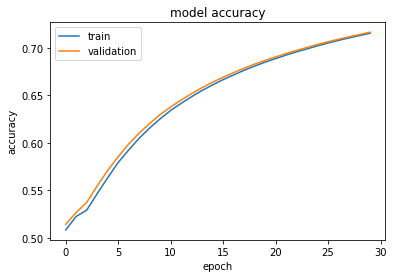

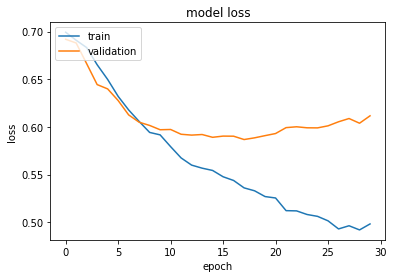

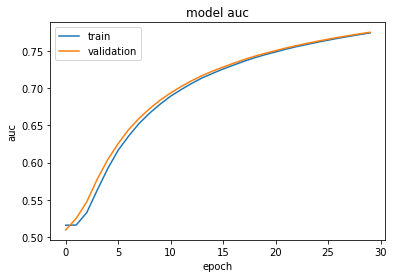


Fold  1
(7200, 250, 20)
(7200, 1)
Train on 7200 samples, validate on 1440 samples
Epoch 1/30
7200/7200 [==============================] - 234s 32ms/sample - loss: 0.7079 - tp: 983.0345 - fp: 968.1724 - tn: 882.8276 - fn: 881.1035 - accuracy: 0.5055 - precision: 0.5080 - recall: 0.5114 - auc: 0.4990 - val_loss: 0.6925 - val_tp: 2491.2500 - val_fp: 2492.7500 - val_tn: 1521.0000 - val_fn: 1508.0000 - val_accuracy: 0.5007 - val_precision: 0.4998 - val_recall: 0.6218 - val_auc: 0.5014
Epoch 2/30
7200/7200 [==============================] - 93s 13ms/sample - loss: 0.6934 - tp: 3934.0862 - fp: 3892.0518 - tn: 2286.2932 - fn: 2242.7068 - accuracy: 0.5033 - precision: 0.5026 - recall: 0.6384 - auc: 0.5040 - val_loss: 0.6914 - val_tp: 4842.8335 - val_fp: 4773.8335 - val_tn: 3559.9167 - val_fn: 3476.4167 - val_accuracy: 0.5046 - val_precision: 0.5036 - val_recall: 0.5825 - val_auc: 0.5043
Epoch 3/30
7200/7200 [==============================] - 33s 5ms/sample - loss: 0.6901 - tp: 5910.3105 - fp: 

Epoch 21/30
7200/7200 [==============================] - 33s 5ms/sample - loss: 0.5509 - tp: 65201.8281 - fp: 38097.7773 - tn: 50167.6367 - fn: 23047.8965 - accuracy: 0.6536 - precision: 0.6312 - recall: 0.7388 - auc: 0.7189 - val_loss: 0.5821 - val_tp: 67009.7500 - val_fp: 38890.7500 - val_tn: 51523.0000 - val_fn: 23389.5000 - val_accuracy: 0.6556 - val_precision: 0.6328 - val_recall: 0.7413 - val_auc: 0.7210
Epoch 22/30
7200/7200 [==============================] - 32s 4ms/sample - loss: 0.5488 - tp: 68831.1406 - fp: 39644.8633 - tn: 52925.6367 - fn: 23753.5000 - accuracy: 0.6576 - precision: 0.6345 - recall: 0.7434 - auc: 0.7232 - val_loss: 0.5826 - val_tp: 70601.1719 - val_fp: 40409.6680 - val_tn: 54324.0859 - val_fn: 24118.0840 - val_accuracy: 0.6594 - val_precision: 0.6360 - val_recall: 0.7454 - val_auc: 0.7253
Epoch 23/30
7200/7200 [==============================] - 33s 5ms/sample - loss: 0.5400 - tp: 72416.9141 - fp: 41148.9297 - tn: 55733.4492 - fn: 24495.8457 - accuracy: 0.661

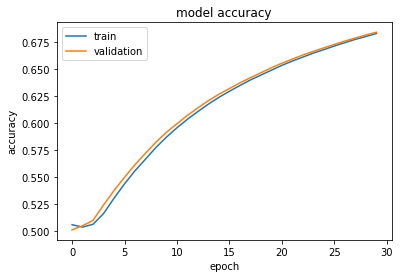

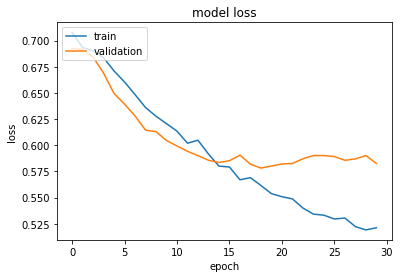

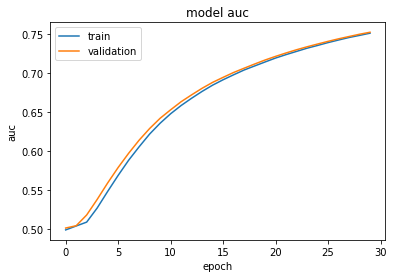


Fold  2
(7200, 250, 20)
(7200, 1)
Train on 7200 samples, validate on 1440 samples
Epoch 1/30
7200/7200 [==============================] - 241s 34ms/sample - loss: 0.7047 - tp: 872.5000 - fp: 866.1896 - tn: 998.8276 - fn: 977.6207 - accuracy: 0.5016 - precision: 0.4978 - recall: 0.4662 - auc: 0.4972 - val_loss: 0.6927 - val_tp: 2180.7500 - val_fp: 2179.1667 - val_tn: 1837.7500 - val_fn: 1815.3334 - val_accuracy: 0.5015 - val_precision: 0.5002 - val_recall: 0.5444 - val_auc: 0.5016
Epoch 2/30
7200/7200 [==============================] - 94s 13ms/sample - loss: 0.6922 - tp: 3667.8103 - fp: 3630.3621 - tn: 2540.6035 - fn: 2516.3621 - accuracy: 0.5023 - precision: 0.5024 - recall: 0.5925 - auc: 0.5060 - val_loss: 0.6893 - val_tp: 4945.2500 - val_fp: 4780.0835 - val_tn: 3556.8335 - val_fn: 3370.8335 - val_accuracy: 0.5105 - val_precision: 0.5084 - val_recall: 0.5946 - val_auc: 0.5135
Epoch 3/30
7200/7200 [==============================] - 33s 5ms/sample - loss: 0.6873 - tp: 6023.2588 - fp: 

Epoch 21/30
7200/7200 [==============================] - 33s 5ms/sample - loss: 0.5299 - tp: 65136.5508 - fp: 33323.2227 - tn: 54956.2578 - fn: 23099.1035 - accuracy: 0.6803 - precision: 0.6615 - recall: 0.7382 - auc: 0.7436 - val_loss: 0.5749 - val_tp: 66952.1719 - val_fp: 33999.5859 - val_tn: 56417.3359 - val_fn: 23443.9180 - val_accuracy: 0.6823 - val_precision: 0.6632 - val_recall: 0.7407 - val_auc: 0.7456
Epoch 22/30
7200/7200 [==============================] - 32s 4ms/sample - loss: 0.5276 - tp: 68780.1875 - fp: 34637.1914 - tn: 57932.3633 - fn: 23805.3965 - accuracy: 0.6843 - precision: 0.6651 - recall: 0.7429 - auc: 0.7477 - val_loss: 0.5788 - val_tp: 70549.3359 - val_fp: 35293.5859 - val_tn: 59443.3359 - val_fn: 24166.7500 - val_accuracy: 0.6861 - val_precision: 0.6665 - val_recall: 0.7449 - val_auc: 0.7495
Epoch 23/30
7200/7200 [==============================] - 33s 5ms/sample - loss: 0.5199 - tp: 72374.1406 - fp: 35941.3086 - tn: 60958.2930 - fn: 24521.3965 - accuracy: 0.688

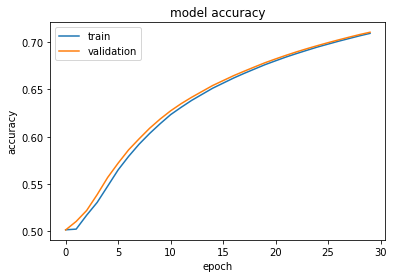

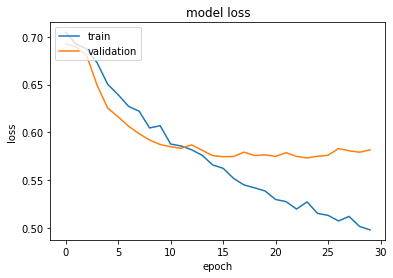

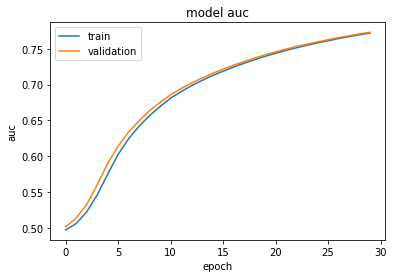


Fold  3
(7200, 250, 20)
(7200, 1)
Train on 7200 samples, validate on 1440 samples
Epoch 1/30
7200/7200 [==============================] - 242s 34ms/sample - loss: 0.7257 - tp: 558.7069 - fp: 561.9138 - tn: 1323.4828 - fn: 1271.0344 - accuracy: 0.5140 - precision: 0.4960 - recall: 0.2378 - auc: 0.5197 - val_loss: 0.6933 - val_tp: 1967.6666 - val_fp: 1962.3334 - val_tn: 2043.0000 - val_fn: 2040.0000 - val_accuracy: 0.5005 - val_precision: 0.5007 - val_recall: 0.4895 - val_auc: 0.5067
Epoch 2/30
7200/7200 [==============================] - 94s 13ms/sample - loss: 0.6932 - tp: 3758.7759 - fp: 3780.1379 - tn: 2405.0688 - fn: 2411.1553 - accuracy: 0.4989 - precision: 0.4985 - recall: 0.6032 - auc: 0.5047 - val_loss: 0.6921 - val_tp: 5505.8335 - val_fp: 5527.1670 - val_tn: 2798.1667 - val_fn: 2821.8335 - val_accuracy: 0.4986 - val_precision: 0.4990 - val_recall: 0.6609 - val_auc: 0.5052
Epoch 3/30
7200/7200 [==============================] - 33s 5ms/sample - loss: 0.6909 - tp: 7210.6206 - fp

Epoch 21/30
7200/7200 [==============================] - 33s 5ms/sample - loss: 0.5522 - tp: 71625.7031 - fp: 44398.5859 - tn: 43861.7422 - fn: 16629.1035 - accuracy: 0.6543 - precision: 0.6173 - recall: 0.8116 - auc: 0.7014 - val_loss: 0.6073 - val_tp: 73553.8359 - val_fp: 45283.3359 - val_tn: 45122.0000 - val_fn: 16853.8340 - val_accuracy: 0.6563 - val_precision: 0.6189 - val_recall: 0.8136 - val_auc: 0.7037
Epoch 22/30
7200/7200 [==============================] - 34s 5ms/sample - loss: 0.5436 - tp: 75473.8984 - fp: 46139.3945 - tn: 46444.9297 - fn: 17096.9141 - accuracy: 0.6585 - precision: 0.6206 - recall: 0.8153 - auc: 0.7060 - val_loss: 0.6115 - val_tp: 77424.8359 - val_fp: 47053.5000 - val_tn: 47671.8359 - val_fn: 17302.8340 - val_accuracy: 0.6603 - val_precision: 0.6220 - val_recall: 0.8173 - val_auc: 0.7079
Epoch 23/30
7200/7200 [==============================] - 33s 5ms/sample - loss: 0.5432 - tp: 79387.5547 - fp: 47942.7930 - tn: 48958.1367 - fn: 17506.6543 - accuracy: 0.662

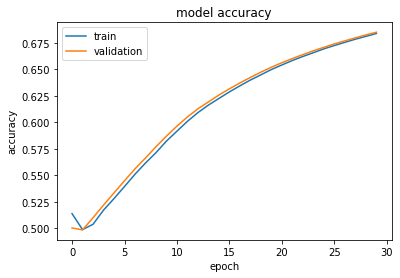

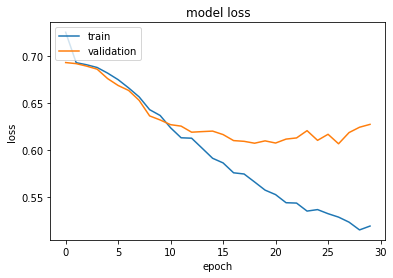

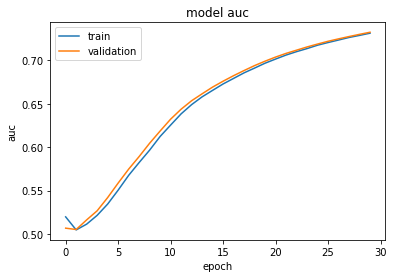


Fold  4
(7200, 250, 20)
(7200, 1)
Train on 7200 samples, validate on 1440 samples
Epoch 1/30
7200/7200 [==============================] - 233s 32ms/sample - loss: 0.7052 - tp: 749.4828 - fp: 718.0862 - tn: 1152.3448 - fn: 1095.2241 - accuracy: 0.5131 - precision: 0.5106 - recall: 0.4399 - auc: 0.5114 - val_loss: 0.6920 - val_tp: 1818.7500 - val_fp: 1731.0834 - val_tn: 2285.1667 - val_fn: 2178.0000 - val_accuracy: 0.5121 - val_precision: 0.5122 - val_recall: 0.4537 - val_auc: 0.5095
Epoch 2/30
7200/7200 [==============================] - 94s 13ms/sample - loss: 0.6900 - tp: 3016.7241 - fp: 2778.7759 - tn: 3404.8103 - fn: 3154.8276 - accuracy: 0.5194 - precision: 0.5203 - recall: 0.4895 - auc: 0.5187 - val_loss: 0.6881 - val_tp: 4051.0000 - val_fp: 3586.5000 - val_tn: 4749.7500 - val_fn: 4265.7500 - val_accuracy: 0.5284 - val_precision: 0.5303 - val_recall: 0.4870 - val_auc: 0.5284
Epoch 3/30
7200/7200 [==============================] - 33s 5ms/sample - loss: 0.6842 - tp: 5161.9482 - fp

Epoch 21/30
7200/7200 [==============================] - 33s 5ms/sample - loss: 0.5081 - tp: 66014.3984 - fp: 31428.1543 - tn: 56828.1562 - fn: 22244.4316 - accuracy: 0.6959 - precision: 0.6775 - recall: 0.7479 - auc: 0.7566 - val_loss: 0.5980 - val_tp: 67868.4219 - val_fp: 32133.9180 - val_tn: 58282.3359 - val_fn: 22528.3340 - val_accuracy: 0.6977 - val_precision: 0.6787 - val_recall: 0.7508 - val_auc: 0.7584
Epoch 22/30
7200/7200 [==============================] - 33s 5ms/sample - loss: 0.5112 - tp: 69737.0703 - fp: 32805.5000 - tn: 59782.6875 - fn: 22829.8789 - accuracy: 0.6995 - precision: 0.6801 - recall: 0.7534 - auc: 0.7602 - val_loss: 0.5963 - val_tp: 71610.5000 - val_fp: 33515.4180 - val_tn: 61220.8359 - val_fn: 23106.2500 - val_accuracy: 0.7011 - val_precision: 0.6812 - val_recall: 0.7560 - val_auc: 0.7617
Epoch 23/30
7200/7200 [==============================] - 33s 5ms/sample - loss: 0.5009 - tp: 73490.5859 - fp: 34203.8945 - tn: 62696.1875 - fn: 23404.4648 - accuracy: 0.702

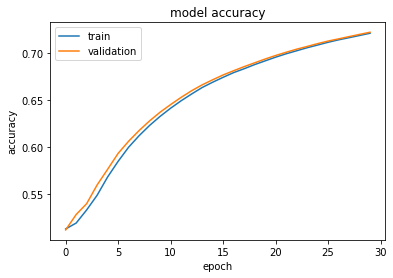

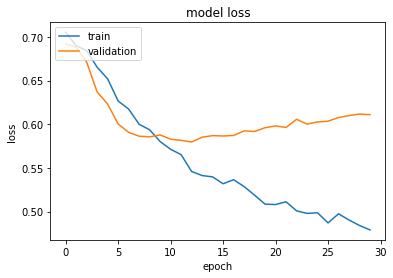

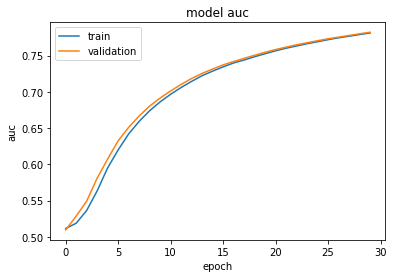


Fold  5
(7200, 250, 20)
(7200, 1)
Train on 7200 samples, validate on 1440 samples
Epoch 1/30
7200/7200 [==============================] - 243s 34ms/sample - loss: 0.7044 - tp: 879.8276 - fp: 900.6896 - tn: 960.3793 - fn: 974.2414 - accuracy: 0.4949 - precision: 0.4962 - recall: 0.4926 - auc: 0.4937 - val_loss: 0.6917 - val_tp: 2028.9166 - val_fp: 2014.9166 - val_tn: 1992.5000 - val_fn: 1976.6666 - val_accuracy: 0.5017 - val_precision: 0.5015 - val_recall: 0.5053 - val_auc: 0.5014
Epoch 2/30
7200/7200 [==============================] - 94s 13ms/sample - loss: 0.6891 - tp: 3300.3965 - fp: 3125.3276 - tn: 3040.9827 - fn: 2888.4309 - accuracy: 0.5125 - precision: 0.5130 - recall: 0.5340 - auc: 0.5135 - val_loss: 0.6774 - val_tp: 4346.9170 - val_fp: 3939.5000 - val_tn: 4387.9170 - val_fn: 3978.6667 - val_accuracy: 0.5245 - val_precision: 0.5245 - val_recall: 0.5222 - val_auc: 0.5317
Epoch 3/30
7200/7200 [==============================] - 33s 5ms/sample - loss: 0.6739 - tp: 5472.5171 - fp: 

Epoch 21/30
7200/7200 [==============================] - 33s 5ms/sample - loss: 0.5185 - tp: 62553.6367 - fp: 29950.6719 - tn: 58315.3789 - fn: 25695.4473 - accuracy: 0.6847 - precision: 0.6762 - recall: 0.7088 - auc: 0.7512 - val_loss: 0.5678 - val_tp: 64283.0859 - val_fp: 30580.3340 - val_tn: 59827.0859 - val_fn: 26122.5000 - val_accuracy: 0.6864 - val_precision: 0.6776 - val_recall: 0.7111 - val_auc: 0.7531
Epoch 22/30
7200/7200 [==============================] - 33s 5ms/sample - loss: 0.5251 - tp: 65990.0703 - fp: 31165.2578 - tn: 61404.3945 - fn: 26595.4141 - accuracy: 0.6880 - precision: 0.6792 - recall: 0.7127 - auc: 0.7550 - val_loss: 0.5696 - val_tp: 67726.5859 - val_fp: 31836.0000 - val_tn: 62891.4180 - val_fn: 26999.0000 - val_accuracy: 0.6894 - val_precision: 0.6802 - val_recall: 0.7150 - val_auc: 0.7565
Epoch 23/30
7200/7200 [==============================] - 33s 5ms/sample - loss: 0.5073 - tp: 69492.6406 - fp: 32474.1543 - tn: 64424.6016 - fn: 27403.7422 - accuracy: 0.691

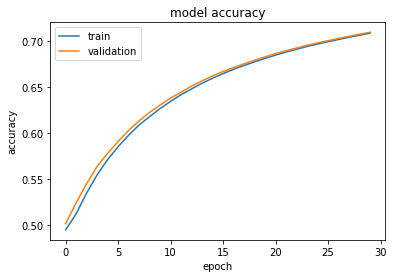

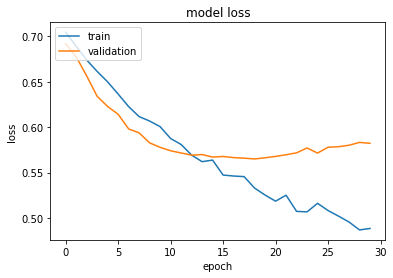

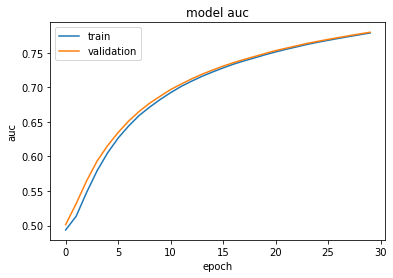

In [34]:
for j, (train_idx, val_idx) in enumerate(folds):
    # We need to clear the session to enable JIT in the middle of the program.
    tf.keras.backend.clear_session()
    tf.config.optimizer.set_jit(True) # Enable XLA.
    
    model = generate_model(Tx, Ty, n_a, n_s, 20)
    model = compile_model(model)
    
    print('\nFold ',j)
    X_train_cv = X_train[train_idx]
    y_train_cv = y_train[train_idx]
    X_valid_cv = X_train[val_idx]
    y_valid_cv= y_train[val_idx]
    m = X_train_cv.shape[0]
    print(X_train_cv.shape)
    print(y_train_cv.shape)
    s0 = np.zeros((m, n_s))
    c0 = np.zeros((m, n_s))
    m_ = X_valid_cv.shape[0]
    s_0 = np.zeros((m_, n_s))
    c_0 = np.zeros((m_, n_s))

    history = train_model(model, X_train_cv, y_train_cv, s0, c0, X_valid_cv, s_0, c_0, y_valid_cv, epochs = 30)
#     print(history.history.keys())
    plotFig(history)
    

In [35]:
#70.1%
# save model and architecture to single file
model.save("model.h5")